## Import Libraries

In [2]:
#For data processing
import pandas as pd
import numpy as np
import datetime as dt

#For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For training and evaluating models 
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

## Load Data
We'll be looking at Goldman Sachs (GS) stock price data

In [3]:
df = pd.read_csv('gs.us.txt')
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-05-04,67.665,68.780,62.329,62.659,24472946,0
1,1999-05-05,62.213,62.213,58.991,61.547,8295140,0
2,1999-05-06,60.542,61.773,59.712,60.488,3185852,0
3,1999-05-07,60.488,66.671,59.429,65.998,5331091,0
4,1999-05-10,65.331,65.441,62.549,62.941,2839054,0


In [4]:
#Convert date to datetime value
df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4661 entries, 0 to 4660
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     4661 non-null   datetime64[ns]
 1   Open     4661 non-null   float64       
 2   High     4661 non-null   float64       
 3   Low      4661 non-null   float64       
 4   Close    4661 non-null   float64       
 5   Volume   4661 non-null   int64         
 6   OpenInt  4661 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 255.0 KB


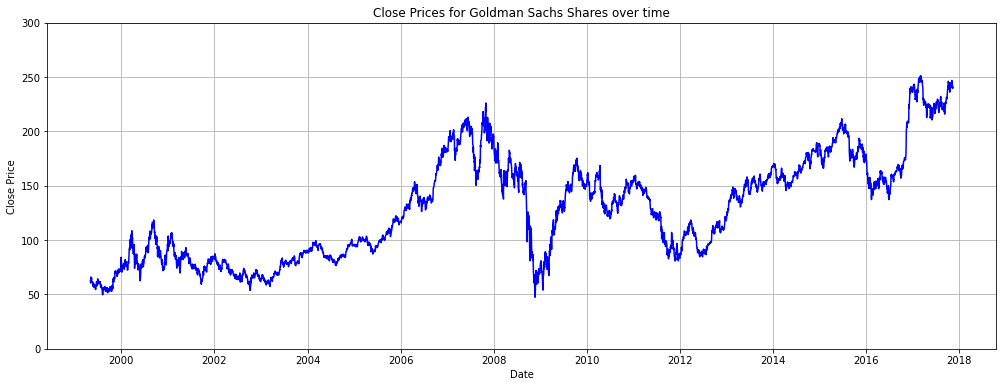

In [6]:
plt.rcParams['figure.figsize'] = (17,6)
plt.grid(True)
plt.plot(df['Date'],df['Close'], color='b')
plt.yticks(np.arange(0,350, 50))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Prices for Goldman Sachs Shares over time')
plt.show()

In [7]:
#Set datetime as the index value
dt = df.copy()
dt = dt.set_index(dt['Date'])
dt = dt.drop(columns=['Date','High','Low','Open','Volume','OpenInt'], axis=1)
dt.head()

,Close
Date,
1999-05-04,62.659
1999-05-05,61.547
1999-05-06,60.488
1999-05-07,65.998
1999-05-10,62.941


## Scaling Data

In [8]:
#Scale all of the data before splitting
sc = MinMaxScaler(feature_range=(0,1))
dt = sc.fit_transform(np.array(dt).reshape(-1,1))
print(df.shape)
print(dt.shape)

(4661, 7)
(4661, 1)


## Split Data into Training and Testing Sets

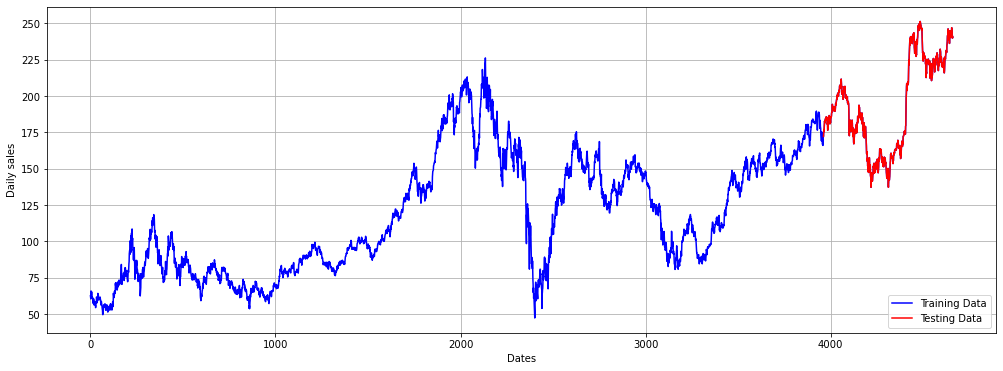

In [9]:
#Visualization of the training-testing data split
test = df[int(len(df)*0.85):]
ax = df['Close'].plot(figsize = (17,6),color='blue', label='Training Data')
ax = test['Close'].plot(figsize = (17,6),color='red', label='Testing Data')
ax.set(xlabel='Dates', ylabel='Daily sales')
ax.legend(loc='lower right')
plt.grid(True)
plt.show()

In [10]:
#Split data into training and testing sets
total_size = len(dt)
train_size = int(total_size * 0.85)
test_size = total_size - train_size
train_set, test_set = dt[0:train_size,:], dt[train_size:total_size, :1]
print(train_set.shape, test_set.shape)

(3961, 1) (700, 1)


## Generate Data with TimeSteps


In [11]:
#convert arrays into matrix
def create_dataset(data, timestep):
    dataX = []
    dataY = []
    numdata = len(data)-timestep-1
    for i in range(numdata):
        val_X = data[i:(i+timestep),0]
        val_Y = data[i+timestep,0]
        dataX.append(val_X)
        dataY.append(val_Y)
    X_arr = np.array(dataX)
    y_arr = np.array(dataY)
    return X_arr, y_arr

In [12]:
#reshape and split our train and test data into X and y
#selecting same timestep for both train and test sets
timestep = 50
X_train, y_train = create_dataset(train_set, timestep)
X_test, y_test = create_dataset(test_set, timestep)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3910, 50)
(3910,)
(649, 50)
(649,)


In [13]:
#Reshape data as 3D array which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3910, 50, 1)
(3910,)
(649, 50, 1)
(649,)


## Construct LSTM Model

In [14]:
#Initialize model
model = Sequential()

#Adding first LSTM layer and dropout regularisation
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.15))

#Adding second LSTM layer
model.add(LSTM(units=50, return_sequences=True))

#Adding third LSTM layer
model.add(LSTM(units=50))

#Output Layer
model.add(Dense(units=1))

In [15]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'] )

In [16]:
#Get summary of the model details
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


## Train LSTM Model

In [17]:
history = model.fit(X_train, y_train, validation_split=0.20, epochs=50, verbose=1)

Epoch 1/50
98/98 [==============================] - 9s 94ms/step - loss: 0.0061 - accuracy: 3.1969e-04 - val_loss: 7.2760e-04 - val_accuracy: 0.0000e+00
Epoch 2/50
98/98 [==============================] - 8s 81ms/step - loss: 0.0012 - accuracy: 3.1969e-04 - val_loss: 6.2434e-04 - val_accuracy: 0.0000e+00
Epoch 3/50
98/98 [==============================] - 8s 77ms/step - loss: 0.0011 - accuracy: 3.1969e-04 - val_loss: 7.9643e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
98/98 [==============================] - 8s 80ms/step - loss: 0.0011 - accuracy: 3.1969e-04 - val_loss: 8.9878e-04 - val_accuracy: 0.0000e+00
Epoch 5/50
98/98 [==============================] - 8s 78ms/step - loss: 0.0010 - accuracy: 3.1969e-04 - val_loss: 5.7867e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
98/98 [==============================] - 8s 77ms/step - loss: 9.6410e-04 - accuracy: 3.1969e-04 - val_loss: 8.0288e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
98/98 [==============================] - 8s 80ms/step - loss: 8.590

## Evaluate Model

In [18]:
#Make predictions using the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [19]:
#Transform data to original form (unscaled values)
y_train_pred = sc.inverse_transform(train_predict)
y_test_pred = sc.inverse_transform(test_predict)

In [20]:
#Finding error produced by model
mae = metrics.mean_absolute_error(y_test, y_test_pred)
mse = metrics.mean_squared_error(y_test,y_test_pred)
rmse = np.sqrt(mse)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 190.26158669662018
Mean Squared Error: 37174.36580189638
Root Mean Squared Error: 192.8065502048527


In [21]:
timestep = 50 #since we took the timestep as 50
#adjust train predictions plot
trainPredPlot = np.empty_like(dt)
trainPredPlot[:,:] = np.nan
trainPredPlot[timestep:len(y_train_pred)+timestep,:] = y_train_pred
#adjust test predictions plot
testPredPlot = np.empty_like(dt)
testPredPlot[:,:] = np.nan
testPredPlot[len(y_train_pred)+(2*timestep)+1:len(dt)-1,:] = y_test_pred

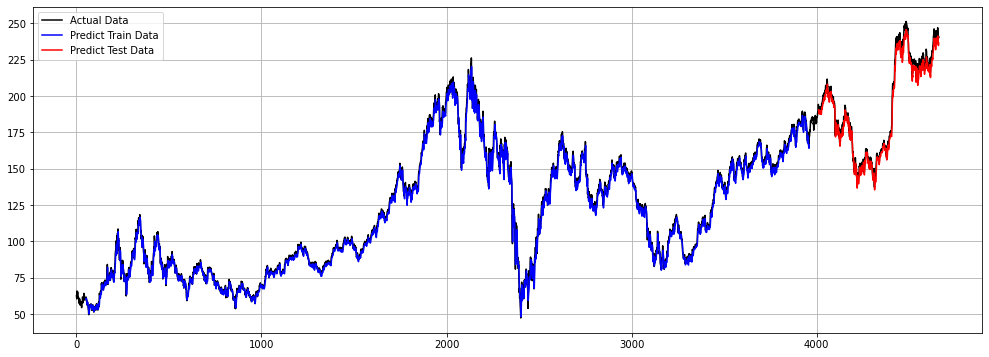

In [22]:
#plot predictions
plt.rcParams['figure.figsize'] = (17,6)
dt_plot = sc.inverse_transform(dt)
plt.plot(dt_plot,color='black', label='Actual Data')
plt.plot(trainPredPlot,color='blue', label='Predict Train Data')
plt.plot(testPredPlot,color='red', label='Predict Test Data')
plt.legend()
plt.grid(True)
plt.show()

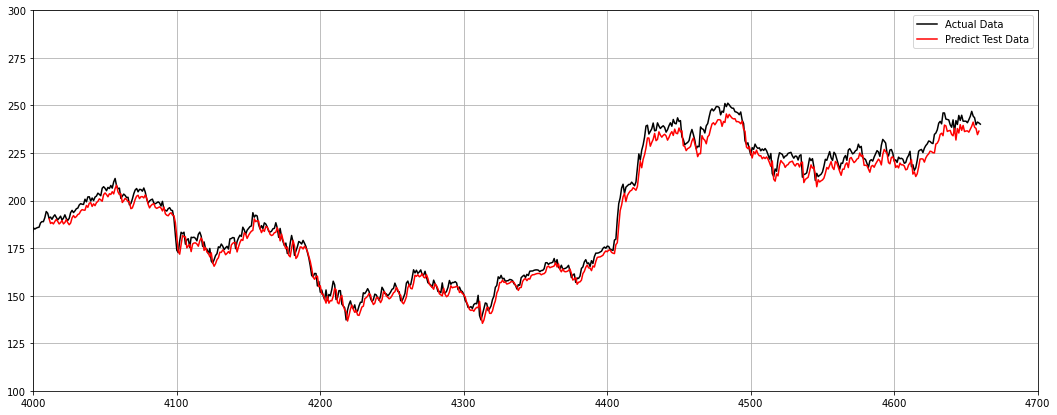

In [23]:
#closer look at test predictions
plt.rcParams['figure.figsize'] = (18,7)
dt_plot = sc.inverse_transform(dt)
plt.plot(dt_plot,color='black', label='Actual Data')
plt.plot(testPredPlot,color='red', label='Predict Test Data')
plt.xlim(4000,4700)
plt.ylim(100,300)
plt.legend()
plt.grid(True)
plt.show()

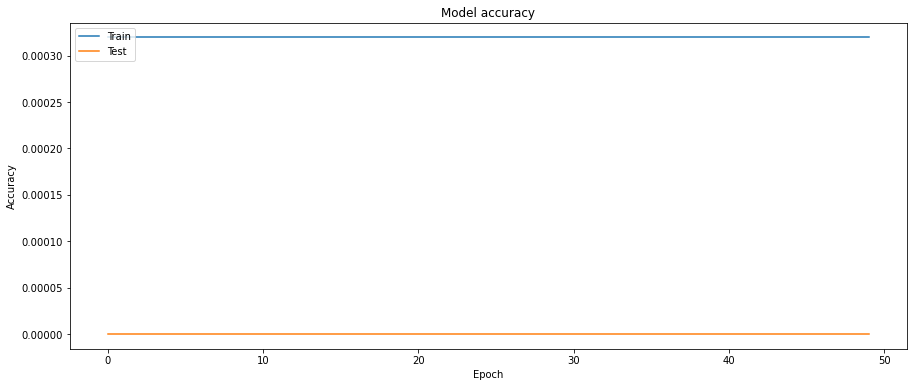

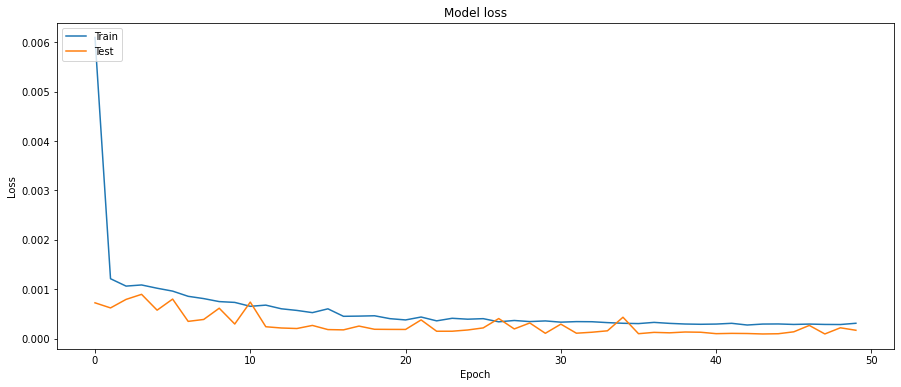

In [24]:
# Plot training & validation accuracy values
plt.rcParams['figure.figsize'] = (15, 6)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()